In [4]:
from ollama import chat
from ollama import ChatResponse
import ollama
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
def add_two_numbers(a: int, b: int) -> int:
  """
  Add two numbers

  Args:
    a: The first integer number
    b: The second integer number

  Returns:
    int: The sum of the two numbers
  """
    
  return int(a) + int(b)
    
response = ollama.chat(
  'llama3.2',
  messages=[{'role': 'user', 'content': 'What is 10 + 10?'}],
  tools=[{
      'type': 'function',
      'function': {
        'name': 'add_two_numbers',
        'description': 'Get the sum of 2 numbers',
        'parameters': {
          'type': 'object',
          'properties': {
            'a': {
              'type': 'float',
              'description': 'The first number',
            }, 
              'b': {
              'type': 'float',
              'description': 'The second number',
            }
          },
          'required': ['a', 'b'],
        },
      },
    },
  ], # Actual function reference
)

available_functions = {
  'add_two_numbers': add_two_numbers,
}

if response.message.tool_calls:
  # There may be multiple tool calls in the response
  for tool in response.message.tool_calls:
    # Ensure the function is available, and then call it
    if function_to_call := available_functions.get(tool.function.name):
      print('Calling function:', tool.function.name)
      print('Arguments:', tool.function.arguments)
      output = function_to_call(**tool.function.arguments)
      print('Function output:', output)
    else:
      print('Function', tool.function.name, 'not found')



# print(response.message.tool_calls)

ConnectError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
def add_two_numbers(a: int, b: int) -> int:
  """
  Add two numbers

  Args:
    a: The first integer number
    b: The second integer number

  Returns:
    int: The sum of the two numbers
  """
    
  return int(a) + int(b)
    
response = ollama.chat(
  'llama3.2',
  messages=[{'role': 'user', 'content': 'What is 10 + 10?'}],
  tools=[add_two_numbers], # Actual function reference
)

available_functions = {
  'add_two_numbers': add_two_numbers,
}

if response.message.tool_calls:
  # There may be multiple tool calls in the response
  for tool in response.message.tool_calls:
    # Ensure the function is available, and then call it
    if function_to_call := available_functions.get(tool.function.name):
      print('Calling function:', tool.function.name)
      print('Arguments:', tool.function.arguments)
      output = function_to_call(**tool.function.arguments)
      print('Function output:', output)
    else:
      print('Function', tool.function.name, 'not found')



# print(response.message.tool_calls)

### Build Custom Class - Tool Calling


In [22]:
class ToolCaller:
    def __init__(self, list_of_tools: [], model = 'llama3.2'):
        self.model = model
        self.list_of_tools = list_of_tools
        self.list_tool_names = [func.__name__ for func in list_of_tools]

    def chat(self, user_prompt, system_prompt = ""):
        response = ollama.chat(
                              self.model,
                              messages=[{'role': 'system', 'content': system_prompt},
                                        {'role': 'user', 'content': user_prompt}],
                              tools=self.list_of_tools)
                            
        available_functions = {
          self.list_tool_names[i]: self.list_of_tools[i] for i in range(len(self.list_of_tools))}


        # Display Output
        self.tool_outputs = {}
        if response.message.tool_calls:
            # There may be multiple tool calls in the response
            for tool in response.message.tool_calls:
                # Ensure the function is available, and then call it
                if function_to_call := available_functions.get(tool.function.name):
                    print('Calling function:', tool.function.name)
                    print('Arguments:', tool.function.arguments)
                    output = function_to_call(**tool.function.arguments)
                    print('Function output:', output)
                    self.tool_outputs[tool.function.name] = output
                else:
                    print('Function', tool.function.name, 'not found')
        
    
            


In [27]:
def square_a_number(x):
    """
    Squares a number
    
    Args:
    x: The number
    
    Returns:
    float: The square of the number
    """
    return int(x)**2
    
tc = ToolCaller(list_of_tools = [square_a_number, add_two_numbers], model = 'llama3.2')

tc.chat(user_prompt = "Square 3 and sum 4 and 6", system_prompt = "")

Calling function: square_a_number
Arguments: {'x': '3'}
Function output: 9
Calling function: add_two_numbers
Arguments: {'a': '4', 'b': '6'}
Function output: 10


In [38]:
def read_a_file(filename):
    """
    reads a file as a dataframe
    
    Args:
    filename: The name of the file
    
    Returns:
    pd.DataFrame: pandas Dataframe
    """
    return pd.read_csv(filename, encoding='utf-8')

tc = ToolCaller(list_of_tools = [square_a_number, add_two_numbers, read_a_file], model = 'llama3.2')

tc.chat(user_prompt = '''read the file called OpenAI97Reviews.csv''', system_prompt = "")
df = tc.tool_outputs['read_a_file']


Calling function: read_a_file
Arguments: {'filename': 'OpenAI97Reviews.csv'}
Function output:     Index                                             Review  \
0       3  I had a very bad experience in that location. ...   
1       4  Took my truck in to get the front brakes repla...   
2       5  I guess any Ford Dealerships in Queens and/or ...   
3       6  Took my 2014 mustang gt for a recall two weeks...   
4       7  Unfortunately had to get towed here, luckily i...   
..    ...                                                ...   
92     95  Henry my adviser is friendly and helpful willi...   
93     96  I came in for an oil change and inspection. I ...   
94     97  They are so so so not professional at all,they...   
95     98  Biggest mistake that people buy ford my car go...   
96     99  Customer service is amazing here, I come to th...   

                                                Topic Sentiment      high  \
0   ['Bad Service', 'Customer Service', 'Service D...  Negat

Calling function: scatter_plot
Arguments: {'x': 'high', 'y': 'low'}
Function output: None


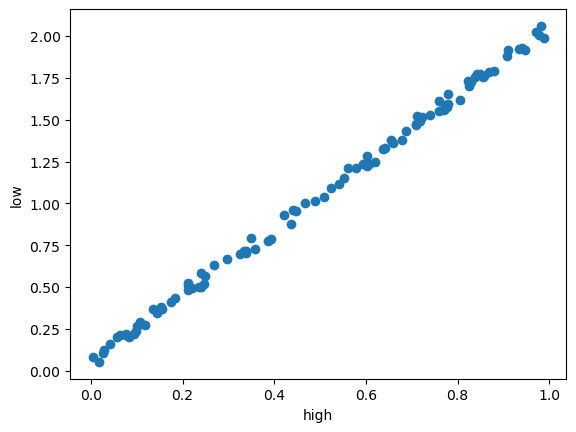

In [45]:
def scatter_plot(x, y):
    """
    makes a scatterplot between 2 variables using matplotlib
    
    Args:
    x: column name 1
    y: column name 2
    
    Returns:
    matplotlib.pyplot: plot
    """
    plt.scatter(df[x], df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    return 

tc = ToolCaller(list_of_tools = [square_a_number, add_two_numbers, read_a_file, scatter_plot], model = 'llama3.2')

tc.chat(user_prompt = '''make a plot between high and low''', system_prompt = "")

'__main__'